# ディープラーニング フレームワーク２

In [202]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


2.公式Example

深層学習フレームワークには公式に様々なモデルのExampleコードが公開されています。

# 【問題1】公式Exampleを分担して実行
# VAE 
コラボでやりました
https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/cvae.ipynb

conv2dtransposeについて　 https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0
https://qiita.com/takurooo/items/9a9f387390f5fcf5a516

このノートブックは、tf.kerasを使って手書き数字のイメージを生成する方法とVariational Autoencoderを訓練することによって熱心に実行する方法を説明します。

In [1]:
# to generate gifs
!pip install imageio

In [2]:
#インポート
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
#MNISTデータのロード
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
#モデル内のベルヌーイ分布で各ピクセルをモデル化し、データセットを静的に2値化します。
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [0]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [0]:
#tf.dataを使用してバッチを作成し、データセットをシャッフルします
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [7]:
train_dataset.output_shapes

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

tf.keras.Sequentialを使用して生成ネットワークと推論ネットワークを接続します。


VAEの例では、生成ネットワークと推論ネットワークに2つの小さなConvNetを使用します。これらのニューラルネットは小さいので、コードを単純化するためにtf.keras.Sequentialを使用します。

Generative Network 生成ネットワーク

これは、入力として潜在的符号化を取り入れ、観測の条件付き分布のためのパラメータを出力する生成モデルを定義する。さらに、潜在変数には事前に単位ガウス分布を使用します。

Inference Network  推論ネットワーク

これは近似事後分布$ q（z | x）$を定義します。これは入力として観測値を取り、潜在表現の条件付き分布のためのパラメータのセットを出力します。 この例では、この分布を単純に対角ガウス分布としてモデル化します。 この場合、推論ネットワークは因数分解されたガウス分布の平均および対数分散パラメータを出力します（分散の代わりに対数分散は数値安定性のためです）。


Reparameterization Trick　再パラメーター化トリック

最適化の間、最初に単位ガウスからサンプリングし、次に標準偏差を掛けて平均を加えることによって、$ q（z | x）$からサンプリングすることができます。 これにより、勾配がサンプルを通過して推論ネットワークパラメータに到達する可能性があります。

Network architecture

推論ネットワークでは、2つの畳み込み層とそれに続く完全接続層を使用します。 生成ネットワークでは、完全に接続された層とそれに続く3つの畳み込み転置層（コンテキストによっては逆畳み込み層）を使用して、このアーキテクチャをミラーリングします。 ミニバッチを使用することによる追加の確率がサンプリングによる確率の上の不安定性を悪化させるかもしれないので、VAEを訓練するときにバッチ正規化を使用することを避けることは一般的なやり方です。


In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2), #if padding=same, outputshape = inputshape(7)* straide 
              padding="SAME",
              activation=tf.nn.relu),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation=tf.nn.relu),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"), #フィルター１にしてるだけ
        ]
    )

  def sample(self, eps=None):
    if eps is None:
      eps = tf.random_normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1) #spritはテンソル分割する
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random_normal(shape=mean.shape) #謎です
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

損失関数とオプティマイザを定義する

限界対数尤度の下限（evidence lower bound （ELBO））を最大化することでVAEトレーニングを行います。

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

実際には、この期待値の単一標本モンテカルロ推定を最適化します。

$$\log p(x| z) + \log p(z) - \log q(z|x),$$

where $z$ is sampled from $q(z|x)$

解析的にKL項を計算することもできますが、ここでは簡単のために3つの項すべてをモンテカルロ推定量に組み込んでいます。



In [0]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x): 
  with tf.GradientTape() as tape: 
    loss = compute_loss(model, x)
  return tape.gradient(loss, model.trainable_variables), loss

optimizer = tf.train.AdamOptimizer(1e-4)
def apply_gradients(optimizer, gradients, variables, global_step=None):
  optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

トレーニング

データセットを反復処理することから始めます。
各繰り返しの間に、近似事後$ q（z | x）$の一組の平均および対数分散パラメータを得るために画像を符号器に渡す。
次に、再パラメータ化トリックを$ q（z | x）$からのサンプリングに適用します。
最後に、再パラメータ化されたサンプルをデコーダに渡して、生成分布$ p（x | z）$のロジットを取得します。
注：トレーニングセット内の60kデータポイントとテストセット内の10kデータポイントを含むkerasによってロードされたデータセットを使用するので、テストセットでのELBOの結果は、LarochelleのMNISTの動的2値化を使用する文献の報告結果よりもわずかに高くなります。

画像を生成する

訓練の後、いくつかの画像を生成する時が来ました
まず、単位ガウス事前分布$ p（z）$から1組の潜在ベクトルをサンプリングすることから始めます。
生成器は、潜在サンプル$ z $を観測値のロジットに変換し、分布$ p（x | z）$を与えます。
ここではベルヌーイ分布の確率をプロットします


In [11]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random_normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  

Epoch: 100, Test set ELBO: -78.21566925048828, time elapse for current epoch 25.306747674942017


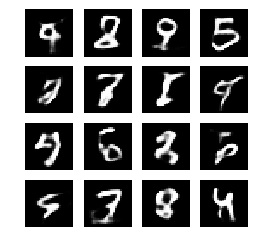

In [13]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    gradients, loss = compute_gradients(model, train_x)
    apply_gradients(optimizer, gradients, model.trainable_variables)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tfe.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

In [0]:
#エポック番号を使って画像を表示する
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

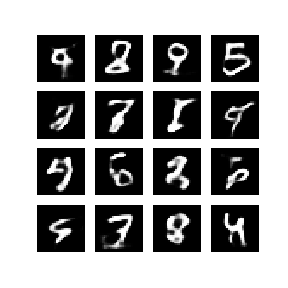

In [122]:
display_image(100)

In [123]:
#保存したすべての画像のGIFを生成します。
with imageio.get_writer('cvae.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp cvae.gif cvae.gif.png')

0

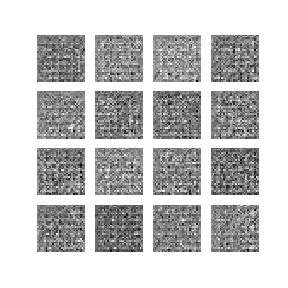

In [125]:
display.Image(filename="cvae.gif.png")

In [17]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131322 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [18]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive/"Colab Notebooks"/pet_data_color2

test  train


In [0]:
#modelのセーブ
filepath = 'drive/Colab Notebooks/tf_vae.h5'
model.save_weights(filepath)

In [0]:
 tekitou = tf.random_normal(shape=[1, latent_dim])

In [147]:
tekitou

<tf.Tensor: id=28616634, shape=(1, 50), dtype=float32, numpy=
array([[ 2.3867836 ,  0.77174675,  0.76348937, -1.6490875 ,  0.1815585 ,
        -0.326712  ,  0.5580485 ,  0.38121414,  0.46467802, -1.5260756 ,
         0.8512148 , -0.63366014,  1.1218506 ,  0.18345748, -0.14915615,
        -0.9312866 ,  0.06578418, -1.9916909 ,  1.1280282 , -0.02749535,
         2.4486258 ,  0.8527257 ,  0.20692177, -0.8491403 , -2.000061  ,
         1.0802562 ,  0.37194842,  1.0045596 , -0.7324801 , -1.3908426 ,
         2.7356153 , -1.8987787 ,  0.14675552, -0.740058  , -0.85909516,
        -0.39109367, -0.90751505, -0.18579113,  0.6740894 , -0.25862747,
         0.71346354,  0.30311608, -0.18756257, -1.270957  ,  3.0178213 ,
        -0.6403679 ,  1.937231  , -0.69343376, -0.61223483,  0.11534449]],
      dtype=float32)>

In [0]:
one = tf.ones([1,50])

In [0]:
pred = model.sample(tekitou + 0.25)

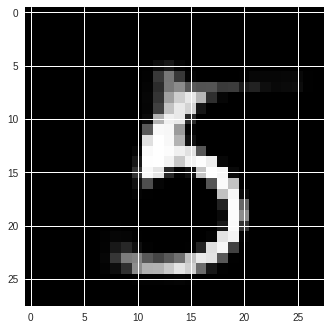

In [174]:
plt.imshow(pred[0, :, :, 0], cmap="gray")

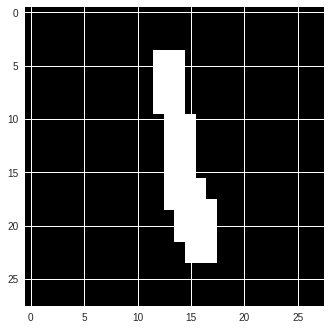

In [179]:
plt.imshow(train_images[6, :, :, 0], cmap="gray")

# 【問題2】Iris（2値分類）をKerasで学習
Sprint14で作成したIrisデータセットに対する2値分類をKerasに書き換えてください。

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data 
y = iris.target 
X = X[:100]
y = y[:100]
y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [207]:
iris_model = tf.keras.Sequential()

inputs = tf.keras.layers.Input(shape=(4,))
x = tf.keras.layers.Dense(50, activation='relu')(inputs)    
x = tf.keras.layers.Dense(100, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_iris = tf.keras.Model(inputs=inputs, outputs=predictions)

model_iris.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_iris.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=10, epochs=10)
#fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None,
#validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, 
#sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)

Train on 64 samples, validate on 16 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
64/64 [==============================] - 0s 5ms/sample - loss: 0.6377 - acc: 0.6875 - val_loss: 0.4953 - val_acc: 1.0000
Epoch 2/10
64/64 [==============================] - 0s 626us/sample - loss: 0.4613 - acc: 1.0000 - val_loss: 0.3635 - val_acc: 1.0000
Epoch 3/10
64/64 [==============================] - 0s 673us/sample - loss: 0.3424 - acc: 1.0000 - val_loss: 0.2641 - val_acc: 1.0000
Epoch 4/10
64/64 [==============================] - 0s 665us/sample - loss: 0.2561 - acc: 1.0000 - val_loss: 0.1902 - val_acc: 1.0000
Epoch 5/10
64/64 [==============================] - 0s 594us/sample - loss: 0.1869 - acc: 1.0000 - val_loss: 0.1305 - val_acc: 1.0000
Epoch 6/10
64/64 [==============================] - 0s 598us/sample - loss: 0.1402 - acc: 1.0000 - val_loss: 0.0917 - val_acc: 1.0000
Epoch 7/10
64/64 [==============================] - 0s 611us/sample - loss: 0.0988 - acc: 1.0000 - val_los

# 【問題3】Iris（多値分類）をKerasで学習

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data 
y = iris.target 
#ワンホット化
zero = np.zeros((y.shape[0], 3))
for i in range(len(y)):
    zero[i, y[i]] = 1
y = zero
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [213]:
iris_model = tf.keras.Sequential()

inputs = tf.keras.layers.Input(shape=(4,))
x = tf.keras.layers.Dense(50, activation='relu')(inputs)    
x = tf.keras.layers.Dense(100, activation='relu')(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)

model_iris = tf.keras.Model(inputs=inputs, outputs=predictions)

model_iris.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_iris.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=10, epochs=20)

Train on 96 samples, validate on 24 samples
Epoch 1/20
96/96 [==============================] - 0s 3ms/sample - loss: 1.0363 - acc: 0.4375 - val_loss: 0.9245 - val_acc: 0.4167
Epoch 2/20
96/96 [==============================] - 0s 582us/sample - loss: 0.8857 - acc: 0.6146 - val_loss: 0.8095 - val_acc: 0.7083
Epoch 3/20
96/96 [==============================] - 0s 611us/sample - loss: 0.7813 - acc: 0.6875 - val_loss: 0.7119 - val_acc: 0.7083
Epoch 4/20
96/96 [==============================] - 0s 617us/sample - loss: 0.6844 - acc: 0.6875 - val_loss: 0.6269 - val_acc: 0.7083
Epoch 5/20
96/96 [==============================] - 0s 594us/sample - loss: 0.6084 - acc: 0.6875 - val_loss: 0.5634 - val_acc: 0.7083
Epoch 6/20
96/96 [==============================] - 0s 596us/sample - loss: 0.5584 - acc: 0.7917 - val_loss: 0.5212 - val_acc: 0.9167
Epoch 7/20
96/96 [==============================] - 0s 577us/sample - loss: 0.5041 - acc: 0.7812 - val_loss: 0.4839 - val_acc: 0.7083
Epoch 8/20
96/96 [==

# 【問題4】House PricesをKerasで学習

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# データセットの読み込み
dataset_path ="../sprint14/train.csv"
df = pd.read_csv(dataset_path)
y = df["SalePrice"]
X = df.loc[:,['GrLivArea', 'YearBuilt']]
y = np.array(y)
X = np.array(X)
y = np.log(y) #分布偏ってるのでlog
y = y.astype("f")[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
#標準化
sc = StandardScaler()
X_train = sc.fit_transform(X_train).astype("f")
X_val = sc.transform(X_val).astype("f")
X_test = sc.transform(X_test).astype("f")

/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  wa

In [4]:
iris_model = tf.keras.Sequential()

inputs = tf.keras.layers.Input(shape=(2,))
x = tf.keras.layers.Dense(50, activation='relu')(inputs)    
x = tf.keras.layers.Dense(100, activation='relu')(x)
predictions = tf.keras.layers.Dense(1)(x)

model_iris = tf.keras.Model(inputs=inputs, outputs=predictions)

model_iris.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='mse',
              metrics=['mae'])

model_iris.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=10, epochs=10)

Train on 934 samples, validate on 234 samples
Epoch 1/10
934/934 [==============================] - 1s 1ms/step - loss: 85.3011 - mean_absolute_error: 8.6817 - val_loss: 11.4304 - val_mean_absolute_error: 2.8405
Epoch 2/10
934/934 [==============================] - 0s 259us/step - loss: 9.1214 - mean_absolute_error: 2.2323 - val_loss: 5.3596 - val_mean_absolute_error: 1.7676
Epoch 3/10
934/934 [==============================] - 0s 262us/step - loss: 5.2819 - mean_absolute_error: 1.7130 - val_loss: 2.8272 - val_mean_absolute_error: 1.2988
Epoch 4/10
934/934 [==============================] - 0s 234us/step - loss: 2.8638 - mean_absolute_error: 1.2518 - val_loss: 1.5218 - val_mean_absolute_error: 0.9555
Epoch 5/10
934/934 [==============================] - 0s 259us/step - loss: 1.5407 - mean_absolute_error: 0.9084 - val_loss: 0.8316 - val_mean_absolute_error: 0.7101
Epoch 6/10
934/934 [==============================] - 0s 237us/step - loss: 0.8212 - mean_absolute_error: 0.6655 - val_loss:

# 【問題5】MNISTをKerasで学習

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
# データセットの読み込み
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train.images
y = mnist.train.labels
#X /= 255.0 されてたのでいらない
X = X.reshape(-1, 28,28,1) #フラットになってるのでreshape
X = X.astype("f")
y = y.astype("f")

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [16]:
inputs = tf.keras.layers.Input(shape=(28,28,1))
x = tf.keras.layers.Conv2D(32, (3,3), padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3,3), padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(50, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

model_mnist = tf.keras.Model(inputs=inputs, outputs=predictions)

model_mnist.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_mnist.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=100, epochs=20)

Train on 35200 samples, validate on 8800 samples
Epoch 1/20
35200/35200 [==============================] - 39s 1ms/step - loss: 0.3222 - acc: 0.9028 - val_loss: 0.1096 - val_acc: 0.9655
Epoch 2/20
35200/35200 [==============================] - 48s 1ms/step - loss: 0.0824 - acc: 0.9750 - val_loss: 0.0718 - val_acc: 0.9784
Epoch 3/20
35200/35200 [==============================] - 37s 1ms/step - loss: 0.0516 - acc: 0.9839 - val_loss: 0.0636 - val_acc: 0.9792
Epoch 4/20
35200/35200 [==============================] - 40s 1ms/step - loss: 0.0383 - acc: 0.9873 - val_loss: 0.0546 - val_acc: 0.9824
Epoch 5/20
35200/35200 [==============================] - 45s 1ms/step - loss: 0.0298 - acc: 0.9910 - val_loss: 0.0643 - val_acc: 0.9818
Epoch 6/20
35200/35200 [==============================] - 45s 1ms/step - loss: 0.0209 - acc: 0.9934 - val_loss: 0.0633 - val_acc: 0.9818
Epoch 7/20
35200/35200 [==============================] - 42s 1ms/step - loss: 0.0176 - acc: 0.9941 - val_loss: 0.0627 - val_acc: